# The Ultimate Sphere Observation Table

The tables used here have been made by analyzing the headers of the roughly 200,000 files taken with Sphere since it started. We look for the coordinates and match them to the closest SIMBAD star-like object, under the assumption that all host-stars that have been observed were, well, stars. It is probably save to assume that "almost all" observations that were obtained in pupil-stabilized mode were of stars. You can easily filter for those, more on that later. We take into account the proper motion difference between J2000 and the time of observation. The median difference between header position and adjusted best matching Simbad position is ~1.6" (with a robust standard deviation of ~1"), overall we are pretty close to the pointing accuracy of the VLTs, which is 1" at best, often worse if the guide star is far away. If an object has very large deviations in the "POS_DIFF" column (in arcsec) of the table of observations, it is an indication of a wrong match and should be discarded.

I enforced a brightness limit of J<15 mag for the stellar matching as most high-contrast observations will require a bright star for AO, and a parallax corresponding to smaller than 1 kpc distances.

Most subsequent columns relate to the details of the observations sequence, such as whether it has been taken in continuous waffle mode, the filter, time of observation, total integration time, observing conditions etc. 

Let's import some useful packages and the Sphere_database class.

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.table import Table

from spherical.sphere_database.sphere_database import Sphere_database

Next we read the two tables containing the all observations (up to April 2025) and the table of SPHERE files (that can be used to find files associated with an observation) to make a Sphere_database object.

In [4]:
table_path = Path.home() / "data/sphere/database"
table_of_observations = Table.read(table_path / "table_of_IFS_observations.fits")
table_of_files = Table.read(table_path / "table_of_IFS_files.csv")

database = Sphere_database(
    table_of_observations=table_of_observations,
    table_of_files=table_of_files,
    instrument='IFS',
)

Now let's have a look at the table of observations. You can visualize the table in your browser or in the notebook directly. Here is the example of opening it in the browser, with java script to make it searchable and sortable.
As you can will see it's a big list.

In [5]:
database.show_in_browser(summary=None, usable_only=True)

Text(0.5, 0, 'Mean DIMM Seeing (arcsec)')

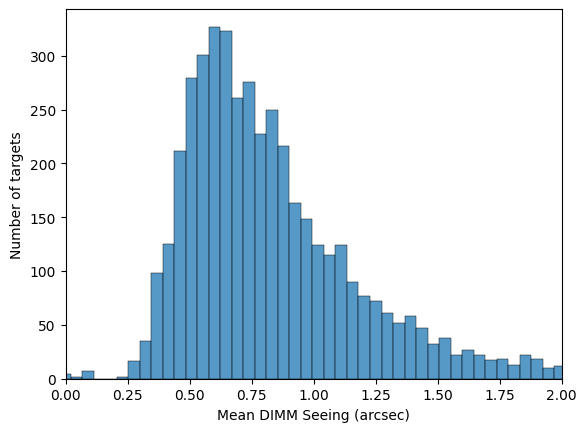

In [7]:
im = sns.histplot(table_of_observations.to_pandas()['MEAN_FWHM'], bins=100)
im.axes.set_xlim(0, 2.)
plt.ylabel('Number of targets')
plt.xlabel('Mean DIMM Seeing (arcsec)')

Let's have a quick look at the difference in position from the header of the SPHERE files used to construct the target list and the catalogue position. Generally the offset is small.

## Example of filtering for observations

In [8]:
print(f"Number of total observations: {len(table_of_observations)}")
print(f"Number of unique targets: {len(np.unique(table_of_observations['MAIN_ID']))}")

Number of total observations: 4488
Number of unique targets: 2276


As you can see SPHERE has been very prolific and many stars have been observed for multiple epochs of observation. However, this list is unwieldy, so let's apply some more filters. We will select only observations that follow some minimum requirement on quality for high-contrast imaging. They should be observed in pupil-stabilized mode for ADI, have a minimum exposure time, should not have any flags that would indicate that they are missing important data (like flux calibration or centering frames) or were aborted (this is summarized in the FAILED_SEQ column). For good measure we also filter for good seeing based on the DIMM values in the header (not the most reliable, but better than nothing), bright stars for good AO performance and a nearby distance below 100 pc.

Of course any other combination or additional filters can be applied, as there is also information such as spectral type of the star, although some additional code might have to be used to filter these properly.

In [9]:
mask = np.logical_and.reduce([
    table_of_observations['DEROTATOR_MODE'] == 'PUPIL',
    table_of_observations['TOTAL_EXPTIME'] > 15.,
    table_of_observations['FAILED_SEQ'] == False,
    table_of_observations['MEAN_FWHM'] < 1.2,
    table_of_observations['FLUX_J'] < 8,
    table_of_observations['DISTANCE'] < 300]
)
print("Number of total observations: {}".format(len(table_of_observations)))
print("Number of good observations fulfilling criteria: {}".format(np.sum(mask)))

Number of total observations: 4488
Number of good observations fulfilling criteria: 1393


In [10]:
table_of_observations[mask].show_in_browser(jsviewer=True)

Text(0.5, 0, 'Distance (pc)')

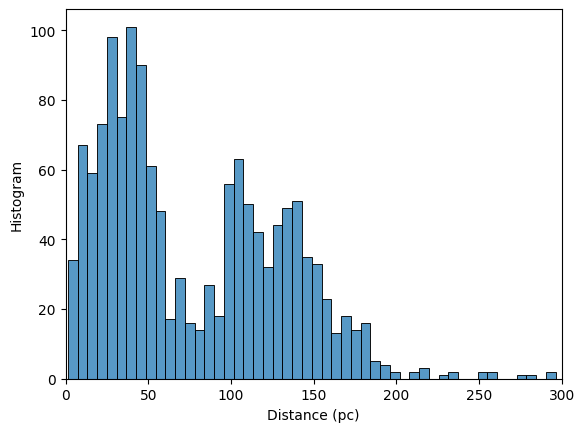

In [11]:
im = sns.histplot(table_of_observations[mask].to_pandas()['DISTANCE'], bins=50)
im.axes.set_xlim(0, 300)
plt.ylabel('Histogram')
plt.xlabel('Distance (pc)')

I defined some additional useful methods in this class, but it mostly makes use of what astropy tables can already do, like displaying the table in your browser with javascript so that you can order the table according to column values and use search functionality. There are two parameters for this function. 

"summary" can either be: None -> display all columns, 'NORMAL' -> gets rid of some columns that may not be immediately interesting, and 'SHORT' to get a very condensed view with only the most important information.
'OBSLOG' -> A digest of important headers

"usable_only" can be True or False. If True, the table is pre-filtered to exclude all observation sequences that have been flagged as "bad" (e.g., missing crucial centering or flux frames, or important calibration data), where not obtained in ADI (pupil stabilized) mode, and have an total exposure time less than 20 minutes. 


In [12]:
database.show_in_browser(summary='SHORT', usable_only=True)

Next, let's take a look at another method of the Sphere_database class: observation_from_name

This method can take the same arguments "summary" and "usable_only", but takes a target name as the first argument. It then resolves the coordinates from the name using Simbad and returns an astropy table with all observations in the observation database that match. Let's try this on beta pictoris...

In [14]:
obs = database.observations_from_name_SIMBAD(['beta pic'], summary='OBSLOG', usable_only=True)
print(obs)

 MAIN_ID  IFS_MODE NIGHT_START WAFFLE_MODE ... MEAN_FWHM MEAN_TAU  OBS_PROG_ID  
--------- -------- ----------- ----------- ... --------- -------- --------------
* bet Pic    OBS_H  2014-12-07        True ...      0.75    0.004   60.A-9382(A)
* bet Pic   OBS_YJ  2015-02-04        True ...      0.79    0.008  095.C-0298(H)
* bet Pic   OBS_YJ  2015-09-30        True ...     1.415    0.001  095.C-0298(D)
* bet Pic   OBS_YJ  2015-11-27        True ...      0.91    0.017  096.C-0241(B)
* bet Pic   OBS_YJ  2015-11-29        True ...     1.078    0.011  096.C-0241(B)
* bet Pic   OBS_YJ  2015-12-25        True ...     1.443    0.002  096.C-0241(C)
* bet Pic   OBS_YJ  2016-01-19        True ...     1.145    0.003  096.C-0241(G)
* bet Pic   OBS_YJ  2016-03-26        True ...     1.636    0.002  096.C-0241(E)
* bet Pic   OBS_YJ  2016-04-15        True ...       0.8    0.006  097.C-0865(A)
* bet Pic   OBS_YJ  2016-09-15        True ...     0.419    0.013  097.C-0865(D)
* bet Pic   OBS_YJ  2016-10-